### Imports

In [1]:
import cv2
import time

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from helpers.limbus_detection import detect_limbus
from helpers.misc import jiggle_circle, tighten_circle, repair_bbox, is_circle_enclosed
from helpers.view_detection import get_view_mask

%load_ext autoreload
%autoreload 2

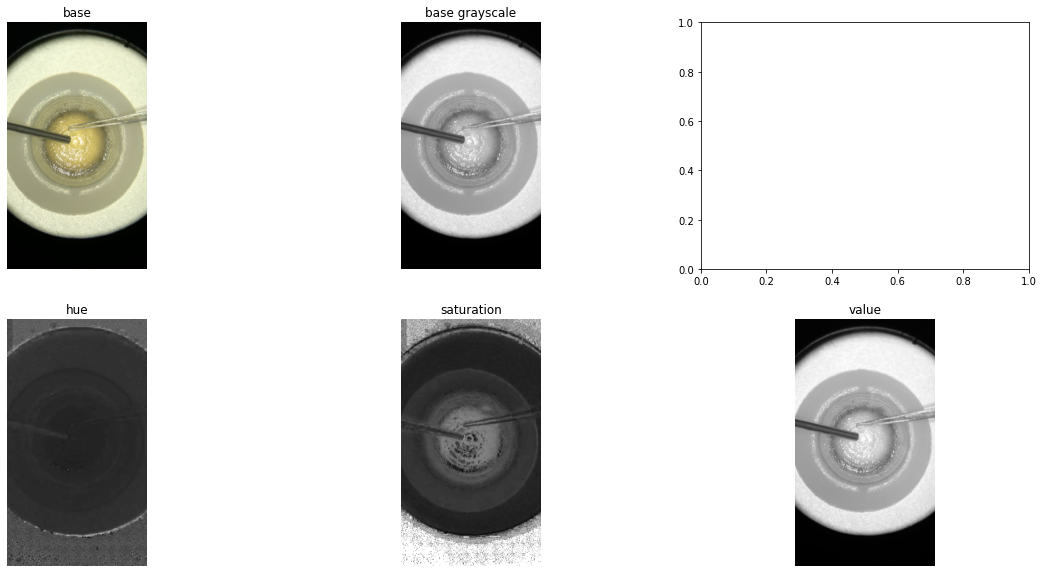

size: 290x512


In [3]:
scale = 0.33

base = cv2.imread('data/artificial/bioniko_rhexis_base3.png', cv2.IMREAD_COLOR)
base = cv2.resize(base, (0,0), fx=scale, fy=scale)

base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:,:,0]
base_saturation = base_hsv[:,:,1]
base_value = base_hsv[:,:,2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)) = plt.subplots(2, 3, figsize=(20,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

print('size: %dx%d' % (base.shape[1], base.shape[0]))

### Naive approach - circle detection with inout validation

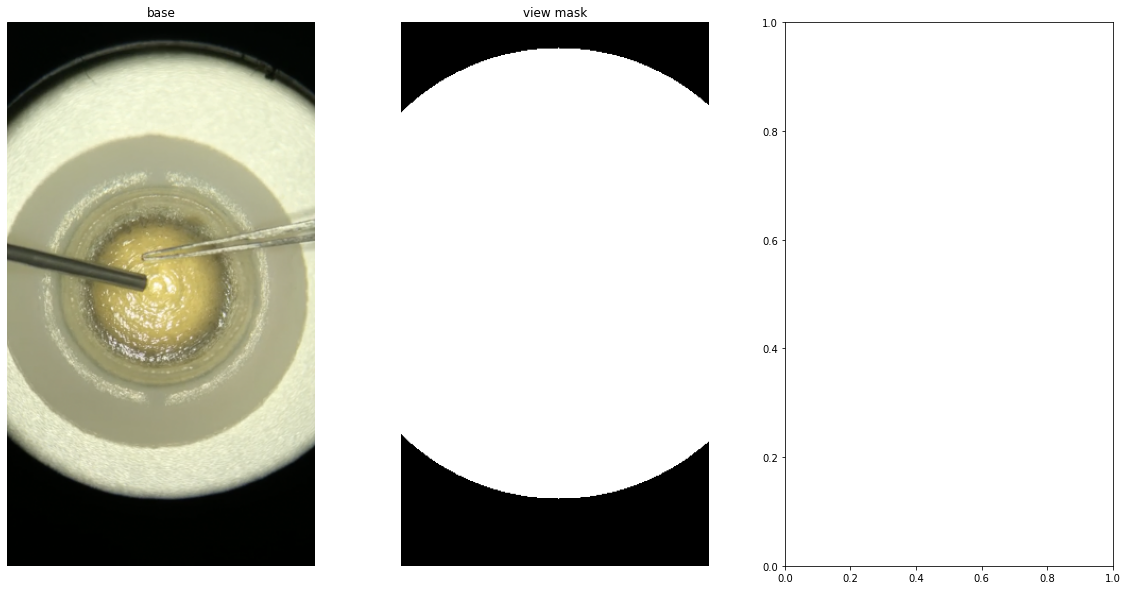

In [5]:
view_mask = get_view_mask(base_gray)
overlaid

fig, plots = plt.subplots(1, 3, figsize=(20,10))
plots[0].set_title('base')
plots[0].imshow(base_rgb)
plots[0].axis('off')

plots[1].set_title('view mask')
plots[1].imshow(view_mask, cmap='gray')
plots[1].axis('off')

plt.show()